In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

# Load your cleaned dataset
df = pd.read_csv("Fully_cleaned.csv")

# Clean and preprocess
df['bed'] = pd.to_numeric(df['bed'], errors='coerce')
df['bath'] = df['bath'].replace(r'\+', '', regex=True)
df['bath'] = pd.to_numeric(df['bath'], errors='coerce')
df = df.dropna(subset=['bed', 'bath', 'Safety_Score'])

# Target transformation
df['Property Value_log'] = np.log1p(df['Property Value'])

# Features and target split
X = df.drop(columns=['Property Value', 'Property Value_log'])
y = df['Property Value_log']

# One-hot encode categoricals
X = pd.get_dummies(X, drop_first=True)

# Replace inf/-inf, fill NaNs
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(X.median())

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=10,         # Number of epochs with no improvement before stopping
    restore_best_weights=True  # Restore the weights of the best epoch
)


In [4]:


# DNN Model
# Standard protocols for regression tasks in deep learning include using a few dense layers with ReLU activations, dropout for regularization, and a final linear layer for output.
# The number of neurons and layers can be adjusted based on the complexity of the dataset and the problem at hand.
model = keras.Sequential([
    layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01),input_shape=(X_train_scaled.shape[1],)),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    # layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    # layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.Dense(32, activation='relu'),
    # layers.Dropout(0.1),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(8, activation='relu'),
    layers.Dense(4, activation='relu'),
    layers.Dense(2, activation='relu'),
    layers.Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train
history = model.fit(
                    X_train_scaled,
                    y_train,
                    epochs=150,
                    batch_size=32,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=[early_stopping]
                    )

# Predict and evaluate
y_pred_log = model.predict(X_test_scaled).flatten()
y_pred = np.expm1(y_pred_log)
y_true = np.expm1(y_test)

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

print(f"✅ RMSE: {rmse:,.2f}")
print(f"✅ R² Score: {r2:.4f}")

c:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/150
217/217 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 82.5710 - mae: 6.8347 - val_loss: 1.5612 - val_mae: 0.5820
Epoch 2/150
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.0546 - mae: 1.0014 - val_loss: 1.4159 - val_mae: 0.5786
Epoch 3/150
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.1301 - mae: 0.8718 - val_loss: 1.9516 - val_mae: 0.9333
Epoch 4/150
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.9148 - mae: 0.8301 - val_loss: 1.1324 - val_mae: 0.5123
Epoch 5/150
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.6293 - mae: 0.7549 - val_loss: 1.0466 - val_mae: 0.5221
Epoch 6/150
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.3999 - mae: 0.6929 - val_loss: 1.2750 - val_mae: 0.7530
Epoch 7/150
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.2600 - mae: 0.6574 - val_loss: 1.3093 - val_mae: 0.7997
Epoch 8/150
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.0501 - mae: 0.6024 - val_loss: 1.2003 - val_mae: 0.7797
Epoch 9/150
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms

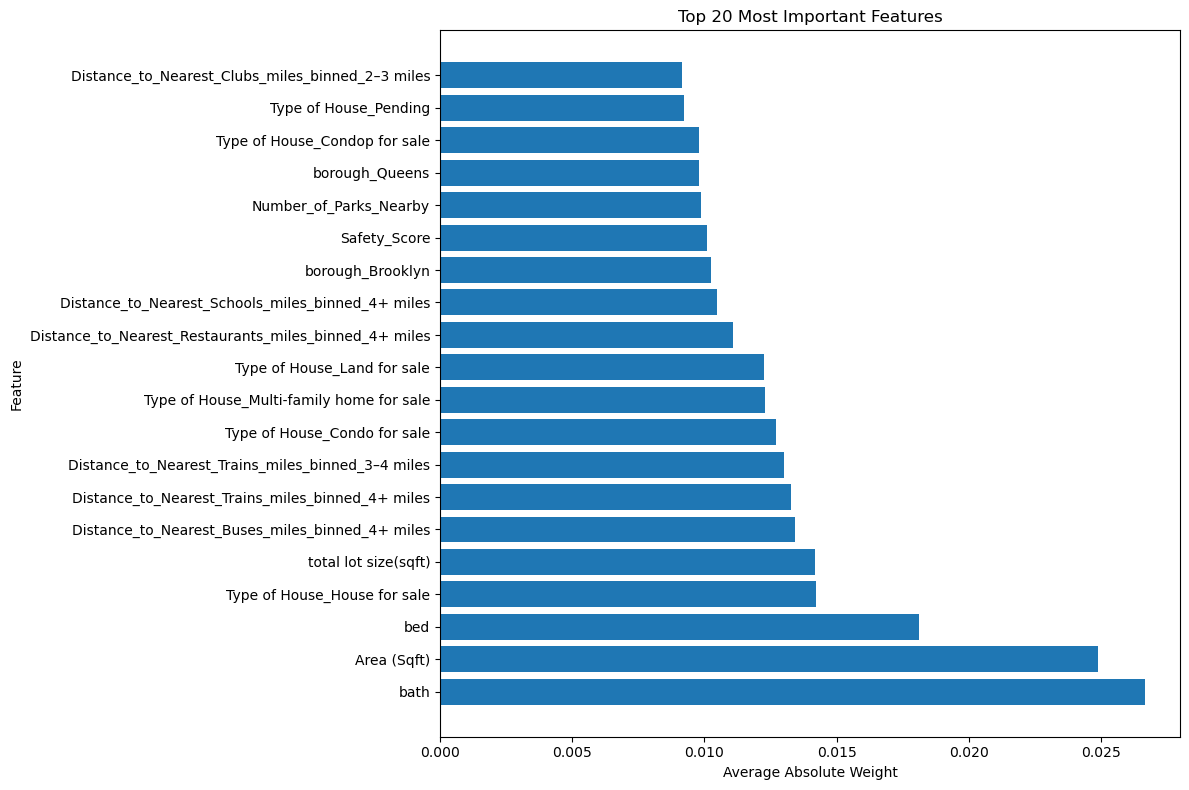


Top 20 Most Important Features:
                                              Feature  Importance
1                                                bath    0.026654
2                                         Area (Sqft)    0.024904
0                                                 bed    0.018104
28                       Type of House_House for sale    0.014205
20                               total lot size(sqft)    0.014168
66    Distance_to_Nearest_Buses_miles_binned_4+ miles    0.013418
70   Distance_to_Nearest_Trains_miles_binned_4+ miles    0.013259
69  Distance_to_Nearest_Trains_miles_binned_3–4 miles    0.013027
24                       Type of House_Condo for sale    0.012692
30           Type of House_Multi-family home for sale    0.012292
29                        Type of House_Land for sale    0.012237
54  Distance_to_Nearest_Restaurants_miles_binned_4...    0.011082
57  Distance_to_Nearest_Schools_miles_binned_4+ miles    0.010482
33                                   boroug

In [13]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

# Calculate feature importance based on model weights
def get_feature_importance(model, feature_names):
    # Get weights from the first dense layer
    weights = np.abs(model.layers[0].get_weights()[0]).mean(axis=1)
    
    # Create a dataframe of features and their importance
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': weights
    })
    
    # Sort by importance
    importance_df = importance_df.sort_values('Importance', ascending=False)
    
    return importance_df

# Get feature importance
feature_names = X_train.columns
importance_df = get_feature_importance(model, feature_names)

# Plot top 20 most important features
plt.figure(figsize=(12, 8))
plt.barh(importance_df['Feature'][:20], importance_df['Importance'][:20])
plt.title('Top 20 Most Important Features')
plt.xlabel('Average Absolute Weight')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# Print numeric values for top 20 features
print("\nTop 20 Most Important Features:")
print(importance_df.head(20))

# Calculate correlation with target variable for numeric features
numeric_features = X_train.select_dtypes(include=['float64', 'int64']).columns
correlations = pd.DataFrame({
    'Feature': numeric_features,
    'Correlation': [np.corrcoef(X_train[feat], y_train)[0,1] for feat in numeric_features]
})

print("\nFeature Correlations with Target (log price):")
print(correlations.sort_values('Correlation', ascending=False))

In [12]:
from tensorflow.keras.callbacks import EarlyStopping
# import sequential from tensorflow.keras.models
from tensorflow.keras.models import Sequential
# Load your cleaned dataset
df = pd.read_csv("bigger_cap_data.csv")

# Clean and preprocess
df['bed'] = pd.to_numeric(df['bed'], errors='coerce')
df['bath'] = df['bath'].replace(r'\+', '', regex=True)
df['bath'] = pd.to_numeric(df['bath'], errors='coerce')
df = df.dropna(subset=['bed', 'bath', 'Safety_Score'])

# Target transformation
df['Property Value_log'] = np.log1p(df['Property Value'])

# Features and target split
X = df.drop(columns=['Property Value', 'Property Value_log'])
y = df['Property Value_log']

# One-hot encode categoricals
X = pd.get_dummies(X, drop_first=True)

# Replace inf/-inf, fill NaNs
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(X.median())

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=10,         # Number of epochs with no improvement before stopping
    restore_best_weights=True  # Restore the weights of the best epoch
)


# DNN Model
# Standard protocols for regression tasks in deep learning include using a few dense layers with ReLU activations, dropout for regularization, and a final linear layer for output.
# The number of neurons and layers can be adjusted based on the complexity of the dataset and the problem at hand.
model = Sequential([
    layers.Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train
history = model.fit(
                    X_train_scaled,
                    y_train,
                    epochs=150,
                    batch_size=32,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=[early_stopping]
                    )

# Predict and evaluate
y_pred_log = model.predict(X_test_scaled).flatten()
y_pred = np.expm1(y_pred_log)
y_true = np.expm1(y_test)

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

print(f"✅ RMSE: {rmse:,.2f}")
print(f"✅ R² Score: {r2:.4f}")

KeyError: ['Safety_Score']

In [5]:
model.save('nyc_property_price_model.h5')

In [6]:
from sklearn.metrics import explained_variance_score

# Calculate explained variance score on log-transformed values
ev_score_log = explained_variance_score(y_test, y_pred_log)

# Calculate explained variance score on original scale
ev_score = explained_variance_score(y_true, y_pred)

print(f"Explained Variance Score (log scale): {ev_score_log:.4f}")
print(f"Explained Variance Score (original scale): {ev_score:.4f}")

Explained Variance Score (log scale): 0.8305
Explained Variance Score (original scale): 0.6571


In [11]:
print("Predictions:",y_pred_log)
print("\n Test:",y_test)

Predictions: [13.42775  14.739968 13.957952 ... 15.205701 13.613333 13.918961]

 Test: 5837    13.541074
7248    14.862830
8152    13.303019
3398    15.084695
7640    13.704580
          ...    
47      14.038655
1015    15.068274
3087    15.084695
8385    13.565768
8177    13.863349
Name: Property Value_log, Length: 1926, dtype: float64


In [43]:
print("Sample Predictions vs Actuals")
for pred, actual in zip(y_pred[:5], y_true[:5]):
    print(f"Predicted: ${pred:,.2f}, Actual: ${actual:,.2f}")


Sample Predictions vs Actuals
Predicted: $795,169.12, Actual: $759,999.00
Predicted: $2,580,695.25, Actual: $2,850,000.00
Predicted: $1,124,468.88, Actual: $599,000.00
Predicted: $3,449,218.25, Actual: $3,557,950.00
Predicted: $957,303.94, Actual: $895,000.00


In [25]:
print("X_train_scaled shape:", X_train_scaled.shape)
print("X_test_scaled shape:", X_test_scaled.shape)
print("Any NaNs in X_train_scaled?", np.isnan(X_train_scaled).any())
print("y_train min/max:", y_train.min(), y_train.max())


X_train_scaled shape: (7700, 86)
X_test_scaled shape: (1926, 86)
Any NaNs in X_train_scaled? False
y_train min/max: 10.819798284210286 15.084695375331187


In [26]:
from sklearn.metrics import mean_squared_error, r2_score

y_pred_log = model.predict(X_test_scaled).flatten()
print("RMSE (log):", np.sqrt(mean_squared_error(y_test, y_pred_log)))
print("R² Score (log):", r2_score(y_test, y_pred_log))


61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
RMSE (log): 0.3352076467725136
R² Score (log): 0.8374844275041415


In [42]:
mean_property_value = df['Property Value'].mean()
rmse_percentage = (rmse / mean_property_value) * 100

print(f"Mean Property Value: ${mean_property_value:,.2f}")
print(f"RMSE: ${rmse:,.2f}")
print(f"RMSE as percentage of mean value: {rmse_percentage:.2f}%")

Mean Property Value: $1,374,211.98
RMSE: $449,040.02
RMSE as percentage of mean value: 32.68%


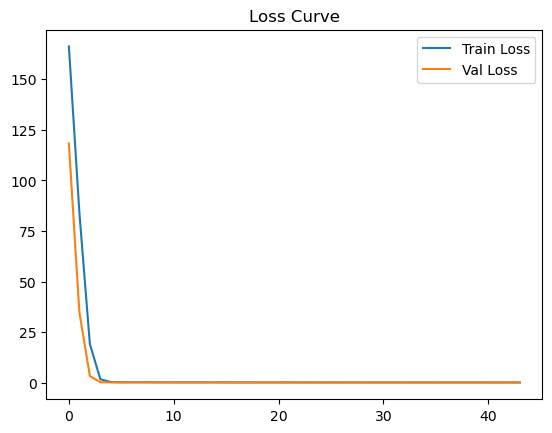

In [40]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss Curve")
plt.show()

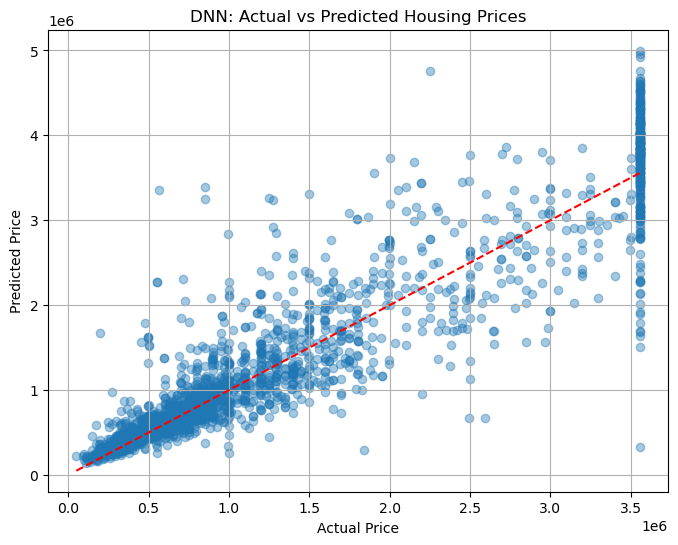

In [41]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_true, y_pred, alpha=0.4)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("DNN: Actual vs Predicted Housing Prices")
plt.grid(True)
plt.show()

In [ ]:
import keras_tuner as kt

def model_builder(hp):
    model = keras.Sequential()
    model.add(layers.Dense(hp.Int('units_input', 64, 512, step=64), activation='relu', input_shape=(X_train_scaled.shape[1],)))
    for i in range(hp.Int("num_layers", 1, 4)):
        model.add(layers.Dense(hp.Int(f'units_{i}', min_value=32, max_value=256, step=32), activation='relu'))
    model.add(layers.Dense(1))

    hp_learning_rate = hp.Choice('learning_rate', [1e-3, 1e-4, 1e-5])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss='mse', metrics=['mae'])
    return model


tuner = kt.RandomSearch(
    model_builder,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=2,
    directory='keras_tuner_dir',
    project_name='house_price_prediction'
)

tuner.search(X_train_scaled, y_train, epochs=100, validation_split=0.1, callbacks=[early_stopping])
best_model = tuner.get_best_models(num_models=1)[0]


Reloading Tuner from keras_tuner_dir\house_price_prediction\tuner0.json


c:\Users\admin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\admin\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [46]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best hyperparameters:")
print(f"Input units: {best_hps.get('units_input')}")
print(f"Number of layers: {best_hps.get('num_layers')}")
for i in range(best_hps.get("num_layers")):
    print(f"Units in layer {i}: {best_hps.get(f'units_{i}')}")
print(f"Learning rate: {best_hps.get('learning_rate')}")

Best hyperparameters:
Input units: 512
Number of layers: 4
Units in layer 0: 224
Units in layer 1: 96
Units in layer 2: 32
Units in layer 3: 32
Learning rate: 0.0001


In [5]:
# Predict on test set
y_pred_log = best_model.predict(X_test_scaled).flatten()
y_pred = np.expm1(y_pred_log)
y_true = np.expm1(y_test)

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

print(f"✅ Tuned RMSE: {rmse:,.2f}")
print(f"✅ Tuned R² Score: {r2:.4f}")


61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
✅ Tuned RMSE: 5,300,908.47
✅ Tuned R² Score: -22.7832
